# Kaggle competition по классификации персонажей мультсериала "Симпсоны"
**[Journey to Springfield competition](https://www.kaggle.com/competitions/journey-springfield/overview)**

## Импорты, настройки, загрузки и т.д.
### Импорт необходимых библиотек

In [1]:
# Импортируем нужные библиотеки

import os
import gc
import random
import kaggle
import pickle
import numpy as np
import pandas as pd
# from skimage import io

from tqdm.notebook import tqdm, trange
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import models, transforms as tfs
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

# import warnings
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)

### Фиксируем ГСЧ

In [2]:
# Сразу ГСЧ зафиксируем, насколько это возможно вообще.
# Всё равно останется некоторая вариативность.

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Закачка и распаковка датасета, установка путей к файлам, проверка доступного девайса

In [3]:
# Качаем и разархивируем данные
# РАСКОММЕНТИРУЙТЕ ЕСЛИ НУЖНО (но должен быть kaggle api установлен , токен получен и аутентификация пройдена)

# !kaggle competitions download -c journey-springfield
# !mkdir simpsons
# !unzip -q journey-springfield.zip  -d simpsons

In [3]:
# Сразу пути к файлам пропишем
TRAIN_DIR = Path('simpsons/train/simpsons_dataset')
TEST_DIR = Path('simpsons/testset')

In [4]:
# определяем доступный девайс
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## Основная часть
### Пишеем свой класс датасета с аугментациями, ресайзом и label-энкодингом.

In [5]:
# Соберём класс датасета.
# Ресайз будем параметром передавать
# Label encoder обучим отдельно на всём трэйн-сете и его тоже будем отправлять в датасет.
# Уберём лишние преобразования изображений. Всё можно средствами пайторча сделать.
# Ресайзить будем так, чтобы не отрезать ничего от кратинки.
# Все изображения к квадратному формату сначала будем приводить.
# Стек трансформов с агументациями тоже будем отдельно подавать в датасет.

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торч-тензоры
    """
    def __init__(self, files, mode, encoder, rescale_size, augments=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.augments = augments
        self.rescale_size = rescale_size
        self.encoder = encoder

        if self.mode not in ['train', 'val', 'test']:
            print(f"{self.mode} is not correct; correct modes: {['train','val','test']}")
            raise NameError

        self.len_ = len(self.files)
     

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            # Поскольку энкодер снаружи подаём - сериализовать и сгружать на диск его не будем.
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        x = self.load_sample(self.files[index])
        
        base_transform = tfs.Compose([
            tfs.CenterCrop(max(x.size)),
            tfs.Resize(self.rescale_size),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        if self.mode == 'test':
            x = base_transform(x)
            return x
        else:
            if self.mode == 'train' and self.augments is not None:
                # Тут вставил в середину аугментации, потому что после нормалайза не очень удачная идея аугментировать.
                # Ну а до ресайза - больше реусрсов отжирать будет
                # (Хотя я не уверен что это удачный вариант кода. Наверно можно что то более лаконичное придумать).
                full_transform = tfs.Compose(base_transform.transforms[:2]+self.augments.transforms + base_transform.transforms[2:])
                x = full_transform(x)
            else:
                x = base_transform(x)
            label = self.labels[index]
            label_id = self.encoder.transform([label])
            y = label_id.item()
            return x, y

### Функция визуализации для тензоров

In [6]:
# Функция визуализации для тензоров
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontdict={'fontsize':11})
    plt_ax.grid(False)

### Функция одной эпохи обучения

In [7]:
# Функция для одной эпохи обучения
# Вместо accuracy будем считать f1_score
# Его нельзя считать по батчам и усреднять в конце, смещение будет ощутиымым.
# Вместо этого будем записывать реальные лэйблы и предикты на каждом батче и в конце считать метрику.
# Усреднение для f1_score будем передавать параметром.
def fit_epoch(model, train_loader, criterion, optimizer, average):
    model.train()
    
    running_loss = 0.0
    epoch_preds = np.empty(0, dtype='int8')
    epoch_real = np.empty(0,dtype='int8')
    
    epoch_correct = 0
    epoch_all = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, -1)
        running_loss += loss.item()
        
        epoch_preds = np.hstack((epoch_preds, preds.cpu()))
        epoch_real = np.hstack((epoch_real, labels.cpu()))
        
        epoch_correct += (preds == labels).sum()
        epoch_all += len(labels)
        
        # Не уверен что всё это надо чистить, но на всякий случай
        inputs.cpu()
        labels.cpu()
        loss.cpu()
        preds.cpu()
        del inputs
        del labels
        del loss
        del preds
        torch.cuda.empty_cache()
              
    train_loss = running_loss / len(train_loader)
    train_acc = epoch_correct.cpu().numpy()/epoch_all
    train_f1 = f1_score(epoch_real, epoch_preds, average=average)
    return train_loss, train_f1, train_acc

### Функция одной эпохи валидации.

In [8]:
# Функция для одной эпохи валидации
# Всё так же как и в трэйн, усреднение для f1 передаем параметром
def eval_epoch(model, val_loader, criterion, average):
    model.eval()
    
    running_loss = 0.0
    epoch_preds = np.empty(0, dtype='int8')
    epoch_real = np.empty(0,dtype='int8')
    
    epoch_correct = 0
    epoch_all = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, -1)

        running_loss += loss.item()
        
        epoch_preds = np.hstack((epoch_preds, preds.cpu()))
        epoch_real = np.hstack((epoch_real, labels.cpu()))
        
        epoch_correct += (preds == labels).sum()
        epoch_all += len(labels)
        
        # Не уверен что всё это надо чистить, но на всякий случай
        inputs.cpu()
        labels.cpu()
        loss.cpu()
        preds.cpu()
        del inputs
        del labels
        del loss
        del preds
    val_loss = running_loss / len(val_loader)
    val_acc = epoch_correct.cpu().numpy()/epoch_all
    val_f1 = f1_score(epoch_real, epoch_preds, average=average)
    return val_loss, val_f1, val_acc

### Функция для предикта.

In [9]:
# Предсказания
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            # Чистим
            inputs.cpu()
            del inputs
            torch.cuda.empty_cache()
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Функция полного цикла обучения

In [10]:
# Весь цикл обучения
# Лоадеры,оптимайзер и scheduler будем грузить отдельно, так настраивать удобнее
def train(train_loader, val_loader, model, optim, criterion, scheduler=None, epochs=10, average='weighted'):
    
    history = []
    best_f1 = 0.0
    best_model_wghts = model.state_dict()
    pbar = trange(epochs, desc="Epoch:")

    for epoch in pbar:
        train_loss, train_f1, train_acc = fit_epoch(model, train_loader, criterion, optim, average)
        val_loss, val_f1, val_acc = eval_epoch(model, val_loader, criterion, average)
        
        history.append((train_loss, train_f1, train_acc, val_loss, val_f1, val_acc))
        
        if scheduler is not None:
            scheduler.step()
        
        # Сохраняем лучшие веса
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wghts = model.state_dict()
        
        pbar.set_description(f'Epoch: {epoch+1} train_loss: {train_loss:.4f} train_f1: {train_f1:.4f} train_acc: {train_acc:.4f} \
                             val_loss: {val_loss:.4f} val_f1: {val_f1:.4f} val_acc: {val_acc:.4f}')
        # Чистим
        torch.cuda.empty_cache()
    # Грузми лучшие веса
    model.load_state_dict(best_model_wghts)    
    return history

### Обрабатываем данные, создаём датасеты, визуализируем.

In [11]:
# Получаем списки файлов для train_val и test.
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

# Создаём и обучаем Label encoder на всех тренировочных данных.
full_set_enc = LabelEncoder()
full_set_labels = [path.parent.name for path in train_val_files]
full_set_enc.fit(full_set_labels);

In [12]:
# Пилим список файлов на тренировочную и валидационную части. Стратифицируем по соотношению классов.
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=full_set_labels, random_state = SEED)

In [13]:
# Зададим базовый рескейл
BASE_RESCALE = 224

In [14]:
# Создаём датасеты
train_dataset = SimpsonsDataset(train_files, mode='train', encoder=full_set_enc, rescale_size=BASE_RESCALE)
val_dataset = SimpsonsDataset(val_files, mode='val', encoder=full_set_enc, rescale_size=BASE_RESCALE)
test_dataset = SimpsonsDataset(test_files, mode='test', encoder=full_set_enc, rescale_size=BASE_RESCALE)

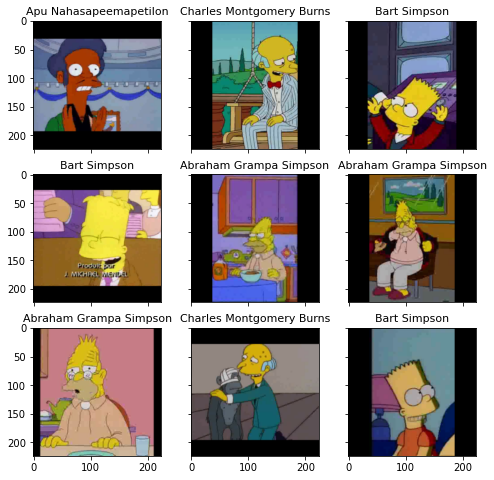

In [15]:
# Визуализируем 9 случайных картинок из валидационного сета.
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Смотрим на распределение классов.

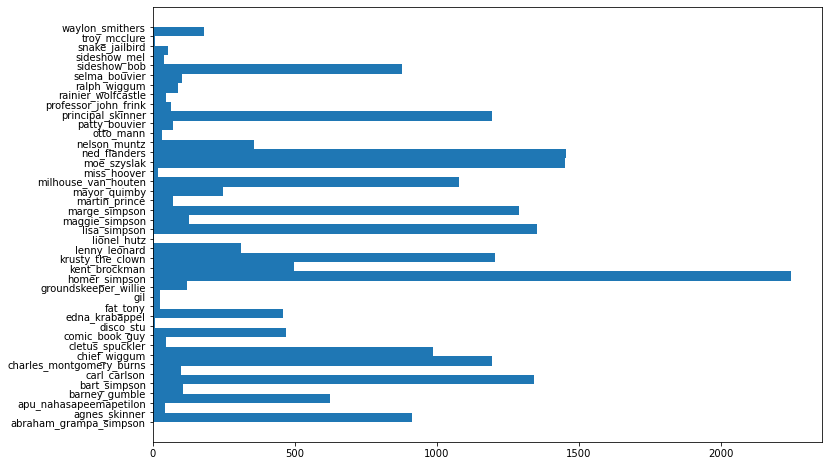

In [16]:
# Посмотрим на баланс нашего сета
plt.figure(figsize=(12,8))
plt.hist(full_set_labels, bins=42, orientation='horizontal');

In [18]:
# Сет не сбалансирован. Попробуем WeightedSampler использовать в Dataloader-е,
# чтобы хоть немного это учитывать.

### Создаём базовые даталоадеры

In [17]:
# Создадим даталоадеры
BATCH_SIZE = 32
NUM_CLASSES = len(np.unique(full_set_labels))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Учим efficient net b0 в самом простом варианте.

In [18]:
# Возьмем самый простой вариант, не будем применять аугментации и взвешенное сэмплирование.
# Просто EfficientNet_b0 с заменой классификатора одним линейным слоем.
effnet_b0 = models.efficientnet_b0(pretrained=True)
effnet_b0.classifier = nn.Linear(1280, 42, bias=True)
effnet_b0.to(DEVICE);

# Зададим лосс функцию и оптимизатор
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(effnet_b0.parameters(), lr=1e-4, amsgrad=True)

In [19]:
# Запустим цикл обучения
# Я выставил значение по-умолчанию для f1_score - 'weighted'
history = train(train_loader, val_loader, effnet_b0, optim, criterion, scheduler=None, epochs=5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

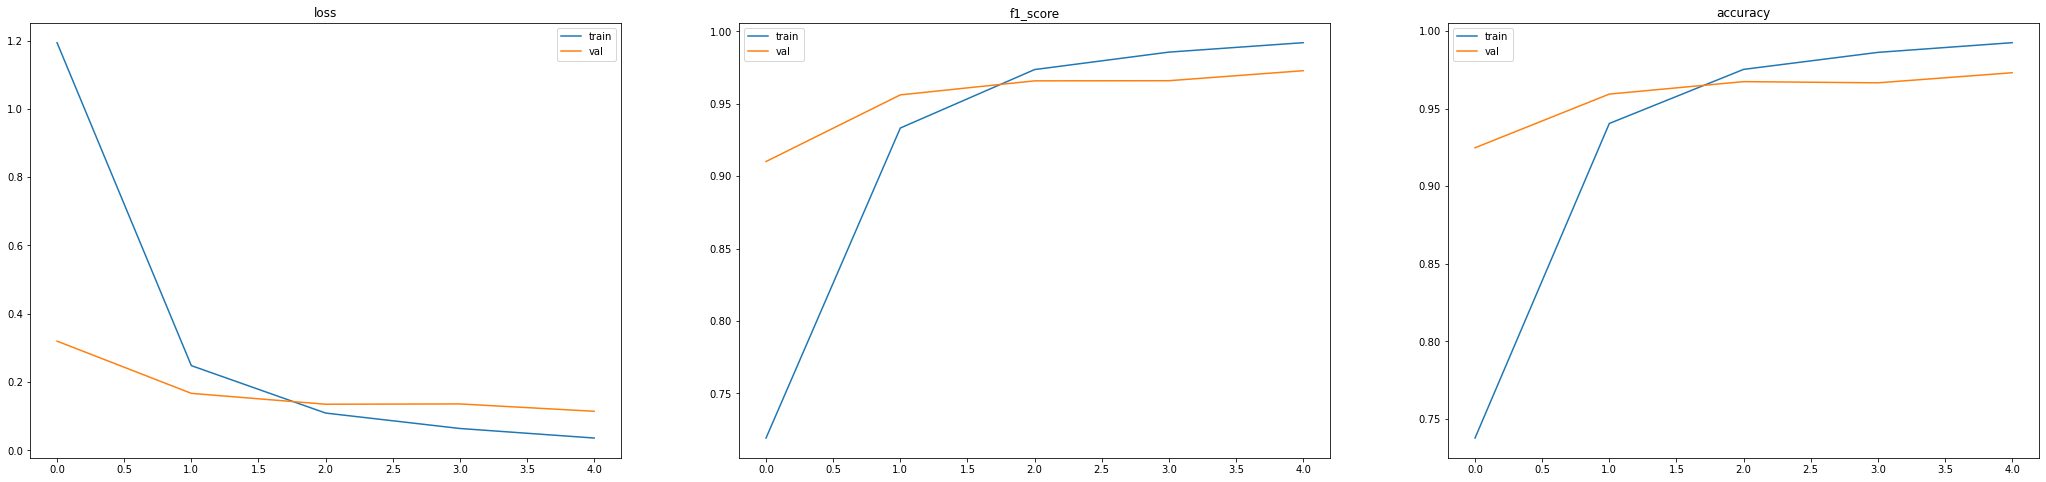

In [20]:
# Построим графики обучения и валидации
fig, axes = plt.subplots(1,3, figsize=(36,8))
for i, data in enumerate(zip(axes.ravel(), ['loss','f1_score', 'accuracy'])):
        data[0].plot(list(zip(*history))[i], label='train')
        data[0].plot(list(zip(*history))[i+3], label='val')
        data[0].set_title(data[1])
        data[0].legend()


In [21]:
# Провалидируемся ещё раз, чтобы удостовериться, что лучшие веса сохранились
_,_,val_f1 = eval_epoch(effnet_b0, val_loader, criterion, 'weighted')
print(f'Weighted f1-score: {val_f1}')

Weighted f1-score: 0.973060756591517


In [22]:
# Получим предсказания на тестовых данных и запишем для сабмита.
probs = predict(effnet_b0, test_loader)

preds = full_set_enc.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


#### Тут скор на kaggle 0.99362

In [23]:
# Сохраняем сабмит
my_submit.to_csv('EfficientNet_b0_submit_v01.csv', index=False)

In [24]:
# На kaggle с этим сабмитом скор получается 0.99362
# Сохраним веса модели
torch.save(effnet_b0.state_dict(), 'effnet_b0_simple_weights.pth')
# Скор конечно отличный, но попробовать какие-нибудь улучшения всё же хочется

### Добавляем аугментации и взвешенное сэмплирование.

In [25]:
# Создадим новый трэйн-лоадер и добавим аугментации
# Посчитаем веса для классов в train датасете и применим WeightedRandomSampler

# Аугментации
augments = tfs.Compose([tfs.RandomHorizontalFlip(), tfs.RandomAffine(degrees=(1.,10.), scale=(.80,1.2), shear=5, translate=(0.1,0.2))])

train_dataset_v02 = SimpsonsDataset(train_files, mode='train', encoder=full_set_enc, rescale_size=BASE_RESCALE, augments=augments)

# Вычисляем веса для train_dataset
_, counts = np.unique(np.array(full_set_enc.transform(train_dataset_v02.labels)), return_counts=True)
weights = 1./counts
samples_weight = np.array([weights[t] for t in full_set_enc.transform(train_dataset_v02.labels)])

# Создаем сэмплер
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

# Создаём даталоадер
train_loader_v02 = DataLoader(train_dataset_v02, batch_size=BATCH_SIZE, sampler=sampler)


In [31]:
# Создаём такую же сетку
effnet_b0_v02 = models.efficientnet_b0(pretrained=True)
effnet_b0_v02.classifier = nn.Linear(1280, 42, bias=True)
effnet_b0_v02.to(DEVICE);

# Зададим лосс функцию и оптимизатор
criterion = nn.CrossEntropyLoss()
optim_v02 = torch.optim.AdamW(effnet_b0_v02.parameters(), lr=2e-4, amsgrad=True)

In [32]:
history_v02 = train(train_loader_v02, val_loader, effnet_b0_v02, optim_v02, criterion, scheduler=None, epochs=5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

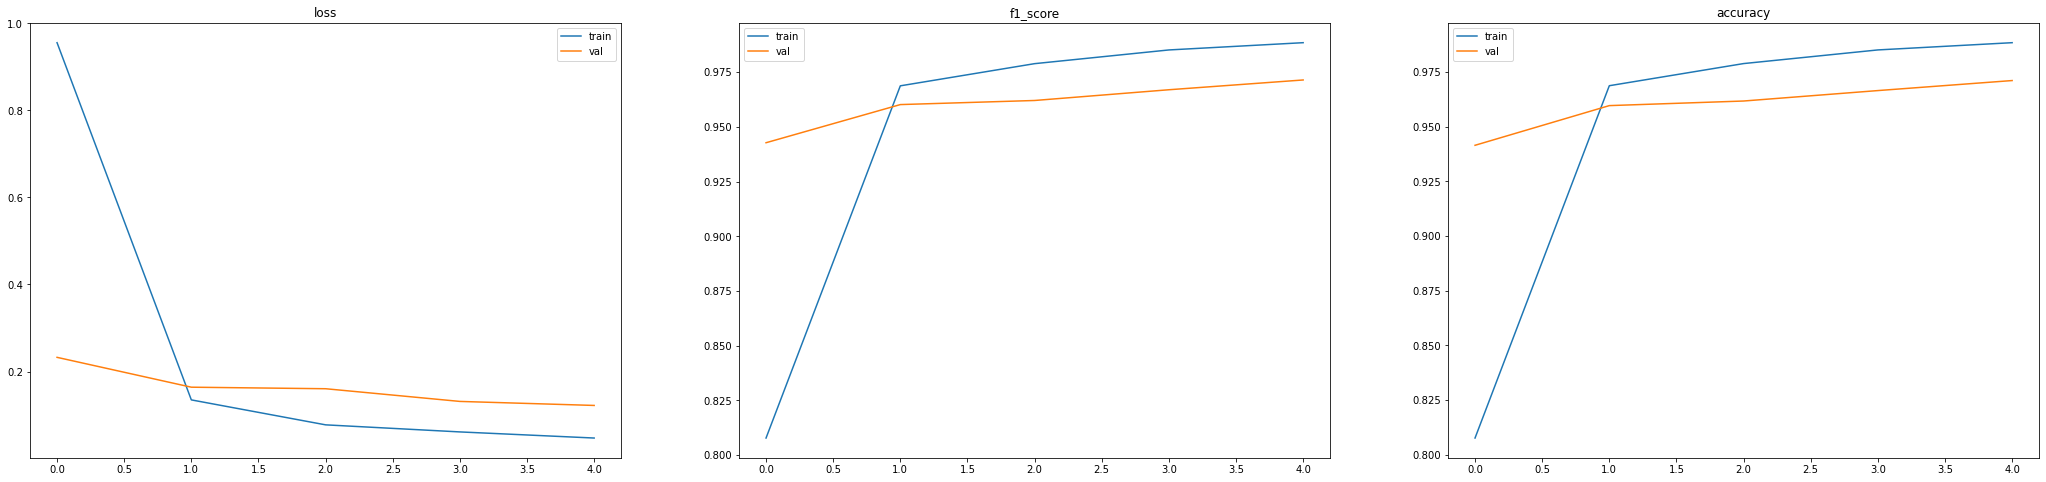

In [33]:
# Построим графики обучения и валидации
fig, axes = plt.subplots(1,3, figsize=(36,8))
for i, data in enumerate(zip(axes.ravel(), ['loss','f1_score', 'accuracy'])):
        data[0].plot(list(zip(*history_v02))[i], label='train')
        data[0].plot(list(zip(*history_v02))[i+3], label='val')
        data[0].set_title(data[1])
        data[0].legend()

In [34]:
# Посчитаем f1_score без усреднения. Чтобы посмотреть как изменились оценки по каждому классу.
_,f1_01,_ = eval_epoch(effnet_b0,val_loader,criterion, average=None)
_,f1_02,_ = eval_epoch(effnet_b0_v02, val_loader, criterion, average=None)

#### Отличия между взвешенным и невзвешенным сэмплированием.

In [37]:
# Посмотрим что изменилось
f1_dataframe = pd.DataFrame({'without_weights':f1_01, 'weighted':f1_02}, index = full_set_enc.classes_ )
f1_dataframe.index.name = 'Name'
f1_dataframe.style.highlight_between(left=0, right=.5,axis=1, props='color:white; font-weight:bold; background-color:red;')
# Видно что теперь определяются все классы.
# Скор на kaggle при этом падает до 0.98724, но опять же это зависит от наличия минорных классов в тестовом датасете.

,without_weights,weighted
Name,,
abraham_grampa_simpson,0.984749,0.971429
agnes_skinner,0.952381,1.000000
apu_nahasapeemapetilon,0.987342,0.987179
barney_gumble,0.807692,0.836364
bart_simpson,0.986627,0.977307
carl_carlson,0.956522,0.979592
charles_montgomery_burns,0.961857,0.973244
chief_wiggum,0.981744,0.979839
cletus_spuckler,0.960000,0.923077


In [36]:
# MICRO AVERAGE
_,f1_01_micro,_ = eval_epoch(effnet_b0,val_loader,criterion, average='micro')
_,f1_02_micro,_ = eval_epoch(effnet_b0_v02, val_loader, criterion, average='micro')
# MACRO AVERAGE
_,f1_01_macro,_ = eval_epoch(effnet_b0,val_loader,criterion, average='macro')
_,f1_02_macro,_ = eval_epoch(effnet_b0_v02, val_loader, criterion, average='macro')
# WEIGHTED AVERAGE
_,f1_01_weighted,_ = eval_epoch(effnet_b0,val_loader,criterion, average='weighted')
_,f1_02_weighted,_ = eval_epoch(effnet_b0_v02, val_loader, criterion, average='weighted')
print('MICRO AVERAGE')
print(f'EfficientNet_B0 without resampling: {f1_01_micro} \nEfficietnNet_B0 with weighted resampling: {f1_02_micro}')
print('MACRO AVERAGE')
print(f'EfficientNet_B0 without resampling: {f1_01_macro} \nEfficietnNet_B0 with weighted resampling: {f1_02_macro}')
print('WEIGHTED AVERAGE')
print(f'EfficientNet_B0 without resampling: {f1_01_weighted} \nEfficietnNet_B0 with weighted resampling: {f1_02_weighted}')

MICRO AVERAGE
EfficientNet_B0 without resampling: 0.973060756591517 
EfficietnNet_B0 with weighted resampling: 0.9711501719526175
MACRO AVERAGE
EfficientNet_B0 without resampling: 0.8915141493790758 
EfficietnNet_B0 with weighted resampling: 0.94745404802834
WEIGHTED AVERAGE
EfficientNet_B0 without resampling: 0.9727603085432083 
EfficietnNet_B0 with weighted resampling: 0.9714300778439555


In [60]:
# Получим предсказания на тестовых данных и запишем для сабмита.
probs = predict(effnet_b0_v02, test_loader)

preds = full_set_enc.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit_v02 = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit_v02.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


#### Тут скор на kaggle 0.98724

In [61]:
# Сохраняем сабмит
my_submit_v02.to_csv('EfficientNet_b0_reweightened_submit_v03.csv', index=False)

In [40]:
# Сохраним веса модели
torch.save(effnet_b0_v02.state_dict(), 'effnet_b0_v02_weights.pth')

### Собираем ансамбль из effnet, densenet и resnet

In [41]:
# Можно попробовать ансамбли.
# Обучим ещё пару каких-нибудь не сильно "тяжелых" сеток.
# Возьмем DenseNet121 и ResNet18
simple_densenet = models.densenet121(pretrained=True)
simple_densenet.classifier = nn.Linear(1024, 42);
simple_densenet.to(DEVICE)

simple_densenet_optim = torch.optim.AdamW(simple_densenet.parameters(),lr=1e-4, amsgrad=True)

In [42]:
simple_densenet_history = train(train_loader, val_loader, simple_densenet, simple_densenet_optim, criterion, scheduler=None, epochs=5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
#Сохраним веса модели
torch.save(simple_densenet.state_dict(), 'simple_densenet_weights.pth')

In [44]:
simple_resnet = models.resnet18(pretrained=True)
simple_resnet.fc = nn.Linear(512,NUM_CLASSES)
simple_resnet.to(DEVICE)

simple_resnet_optim = torch.optim.AdamW(simple_resnet.parameters(),lr=1e-4, amsgrad=True)

In [45]:
simple_resnet_history = train(train_loader, val_loader, simple_resnet, simple_resnet_optim, criterion, scheduler=None, epochs=5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
#Сохраним веса модели
torch.save(simple_resnet.state_dict(), 'simple_resnet_weights.pth')

In [47]:
# "Заморозим" 3 сетки
for net in (effnet_b0, simple_densenet, simple_resnet):
    for param in net.parameters():
        param.requires_grad = False

In [50]:
# Теперь соберём их вместе, сверху повесим пару линейных слоёв.
class MyEnsemble(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net_01 = effnet_b0
        self.net_02 = simple_densenet
        self.net_03 = simple_resnet
        
        self.out = nn.Sequential(
                                     nn.Linear(42*3, 128), 
                                     nn.ReLU(),
                                     nn.Linear(128, 42)
                                     )
    def forward(self,x):
        y1 = self.net_01(x)
        y2 = self.net_02(x)
        y3 = self.net_03(x)
        x = torch.cat((y1,y2,y3), -1)
        logits = self.out(x)
        
        return logits

In [53]:
simple_ensemble = MyEnsemble()
simple_ensemble.to(DEVICE)
simple_ensemble_optim = torch.optim.AdamW(simple_ensemble.out.parameters(),lr=1e-4, amsgrad=True)

In [54]:
simple_ensemble_history = train(train_loader, val_loader, simple_ensemble, simple_ensemble_optim, criterion, scheduler=None, epochs=5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

In [57]:
#Сохраним веса модели
torch.save(simple_ensemble.state_dict(), 'simple_ensemble_weights.pth')

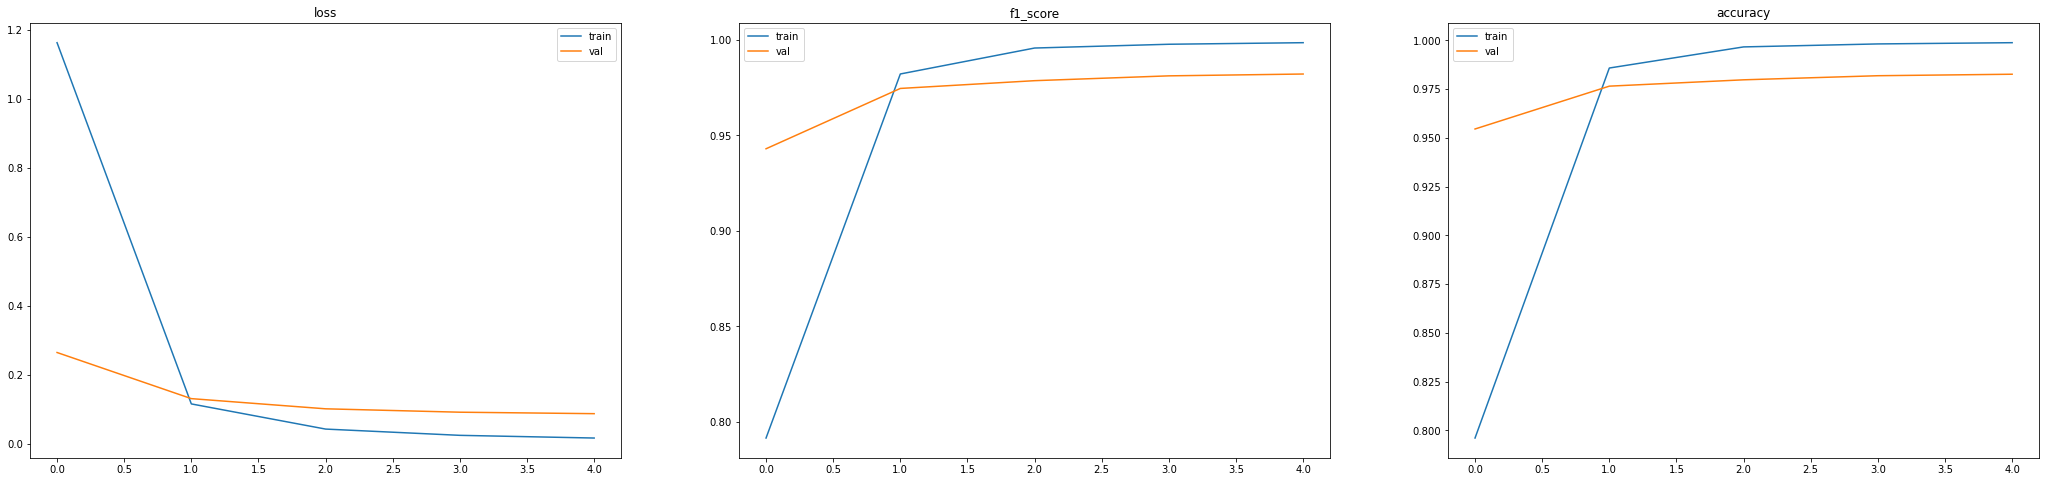

In [55]:
# Построим графики обучения и валидации
fig, axes = plt.subplots(1,3, figsize=(36,8))
for i, data in enumerate(zip(axes.ravel(), ['loss','f1_score', 'accuracy'])):
        data[0].plot(list(zip(*simple_ensemble_history))[i], label='train')
        data[0].plot(list(zip(*simple_ensemble_history))[i+3], label='val')
        data[0].set_title(data[1])
        data[0].legend()

In [58]:
# Получим предсказания на тестовых данных и запишем для сабмита.
probs = predict(simple_ensemble, test_loader)

preds = full_set_enc.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit_v03 = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit_v03.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


#### Тут скор на kaggle 0.99468

In [59]:
# Сохраняем сабмит
my_submit_v03.to_csv('Ensemble_submit_v01.csv', index=False)
## Скор этого сабмита на kaggle 0.9948

### Пробуем собирать датасеты по-другому
**Когда уже всё доделал - пришла идея по-другому собрать датасеты**   
Основная проблема ImageFolder в том, что сложно стратифицированное разбиение на train и test делать.<br>
Можно делать это с помощью sklearn-овского train_test_split и Subset<br>
Но тогда возникает вопрос как применить к train и val сетам разные трансформы.<br>
Придумалось поправить базовый Subset.<br>

In [62]:
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder

In [63]:
# Пути к файлам
TRAIN_DIR = Path('simpsons/train/simpsons_dataset')
TEST_DIR = Path('simpsons/testset')

In [65]:
# Создаем основной сет
full_set = ImageFolder(TRAIN_DIR)

# Создаем просто список индексов от 0 до длины сета - 1. 
# Стратифицируем по targets (там список лэйблов хранится)
# Получаем индексы для train и val сетов. 
train_idxs, val_idxs = train_test_split(list(range(len(full_set))), test_size=0.25, stratify=full_set.targets)

In [70]:
# Добавляем возможность передавать стэк трансформов
# И заворачиваем объекты , которые getitem возвращает - в наши трансформы
# Тут в зависимости от того, один объект или батч нужно либо по списку кортежей пройтись
# либо просто первый элемент кортежа трансформить
class MySubset(Subset):
    def __init__(self, dataset, indices, transform) -> None:
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        if isinstance(idx, list):
            temp = self.dataset[[self.indices[i] for i in idx]]
            out = [(self.transform(pic), label) for pic,label in temp]
            return out
        
        return self.transform(self.dataset[self.indices[idx]][0]), self.dataset[self.indices[idx]][1]

    def __len__(self):
        return len(self.indices)

In [71]:
# Списки трансформов для тренировочного и валидационного сетов
train_tfs = tfs.Compose([
            tfs.Resize(224, max_size=225),
            tfs.CenterCrop(224),
            tfs.RandomHorizontalFlip(),
            tfs.RandomAffine(degrees=(1.,10.), scale=(.80,1.2), shear=5, translate=(0.1,0.2)),
            tfs.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.2),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

val_tfs  = tfs.Compose([
            tfs.Resize(224, max_size=225),
            tfs.CenterCrop(224),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

In [72]:
# Создаем датсеты и даталоадеры
new_train_set = MySubset(full_set, train_idxs, transform=train_tfs)
new_val_set = MySubset(full_set, val_idxs, transform=val_tfs)

new_train_loader = DataLoader(new_train_set, batch_size=8)
new_val_loader = DataLoader(new_val_set, batch_size=8)


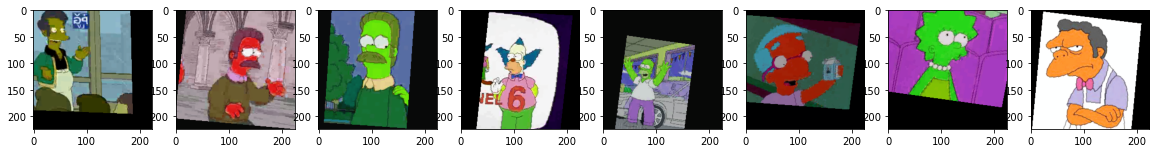

In [73]:
# Визуализируем результаты
plt.figure(figsize=(20,6))
for i,data in enumerate(zip(*next(iter(new_train_loader)))):
    ax = plt.subplot(1,8, i+1)
    imshow(data[0], plt_ax=ax )

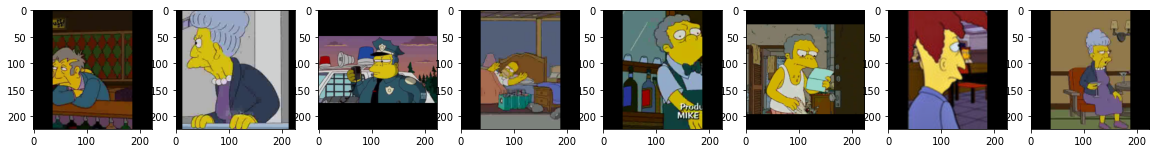

In [74]:
plt.figure(figsize=(20,6))
for i,data in enumerate(zip(*next(iter(new_val_loader)))):
    ax = plt.subplot(1,8, i+1)
    imshow(data[0], plt_ax=ax )

#### Все трансформы правильно применяются. В общем такой вариант довольно удобный и короткий получается. Всего пару строк к стандартному Subset добавить.